In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
#Loading Main Data
data = pd.read_csv('Image_classification_data/data_labels_mainData.csv')
print(data.head())

   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0


In [6]:
#Checking for Nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


**There are no null values in the data**

## EDA

In [44]:
#Check frequency of Categorical features to ensure that there are no errors 
frequency_name = data.groupby('cellTypeName').apply(len)
frequency_int = data.groupby('cellType').apply(len)

print(frequency_name)
print("----")
print(frequency_int)

cellTypeName
epithelial      4079
fibroblast      1888
inflammatory    2543
others          1386
dtype: int64
----
cellType
0    1888
1    2543
2    4079
3    1386
dtype: int64


We can observe that there are no error values in both categorical features and the distribution is equal among both features

0    5817
1    4079
Name: isCancerous, dtype: int64


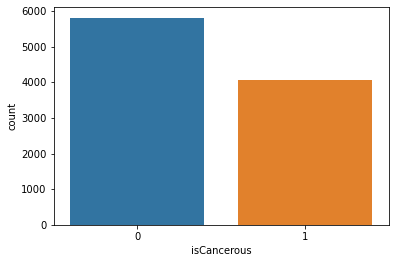

In [5]:
print(data['isCancerous'].value_counts())
sns.countplot(x='isCancerous', data=data)
plt.show()

**We have more instances of non-cancerous images**
**Further exploration is required to confirm any correlations**

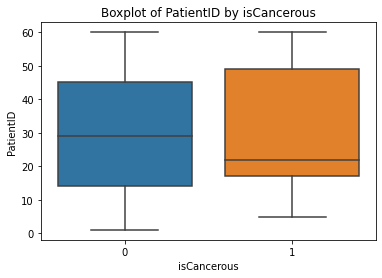

In [17]:
# Boxplots to observe relationship between PatientId and isCancerous
sns.boxplot(x='isCancerous', y='patientID', data=data)
plt.title('Boxplot of PatientID by isCancerous')
plt.xlabel('isCancerous')
plt.ylabel('PatientID')
plt.show()

**No apparent correlation can be found**

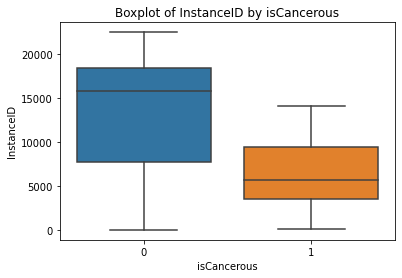

In [14]:
# Plot boxplots of numeric variables
sns.boxplot(x='isCancerous', y='InstanceID', data=data)
plt.title('Boxplot of InstanceID by isCancerous')
plt.xlabel('isCancerous')
plt.ylabel('InstanceID')
plt.show()

**We can see that the initial instanceIDs had much more occurances of cancerous cells rather than the later instances**

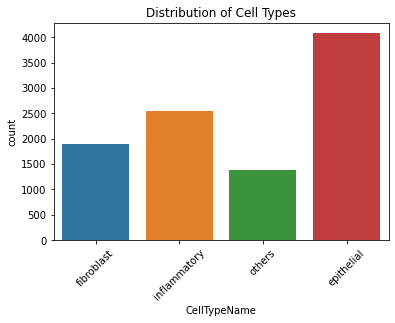

In [21]:
# Check distribution of cell types
sns.countplot(x='cellTypeName', data=data)
plt.title('Distribution of Cell Types')
plt.xlabel('CellTypeName')
plt.xticks(rotation=45)
plt.show()

**We have a notably higher number of epithelial cells as compared to other types of cells**

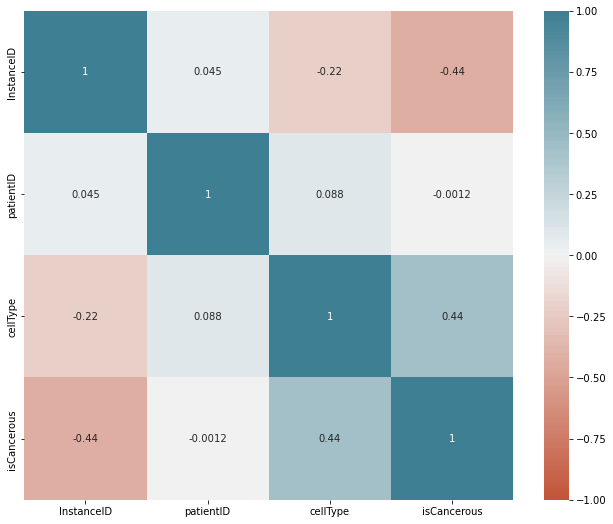

In [25]:
f, ax = plt.subplots(figsize=(11, 9))
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

**Observations**
- As observed with boxplots, a correlation exists between the instance and isCancerous target value
- There is also a correlation between the two target variables: cellType and isCancerous. This can be explored further

In [29]:
from PIL import Image

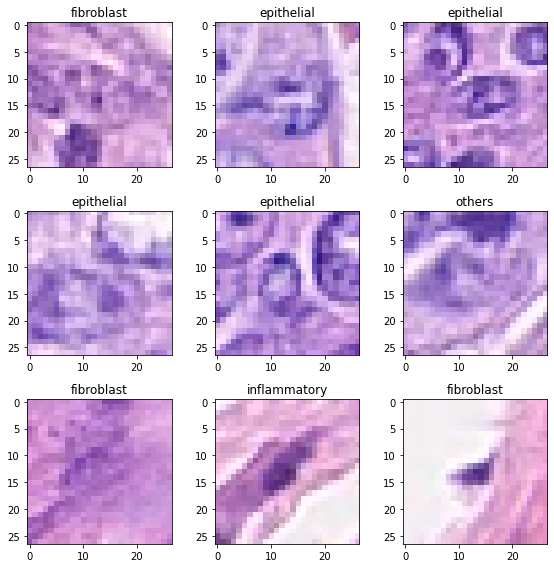

In [32]:
# Display sample images
sample_images = data['ImageName'].sample(9)
plt.figure(figsize=(8,8))
for i, img_name in enumerate(sample_images):
    plt.subplot(3,3,i+1)
    img = Image.open('Image_classification_data/patch_images/' + img_name)
    plt.imshow(img)
    plt.title(data[data['ImageName']==img_name]['cellTypeName'].values[0])
plt.tight_layout()
plt.show()

**Observations**
- While these are random samples, we can see a specific pattern of round purple objects in epithelical cells

In [59]:
# Check for image dimensions
img_dims = []
for img_name in data['ImageName']:
    img = Image.open('Image_classification_data/patch_images/' + img_name)
    img_dims.append(img.size)
img_dims = np.array(img_dims)
print('Image Dimensions:')
print('Min:', np.min(img_dims, axis=0))
print('Max:', np.max(img_dims, axis=0))
print('Mean:', np.mean(img_dims, axis=0))

Image Dimensions:
Min: [27 27]
Max: [27 27]
Mean: [27. 27.]


The images have a consistent size of 27x27 pixels

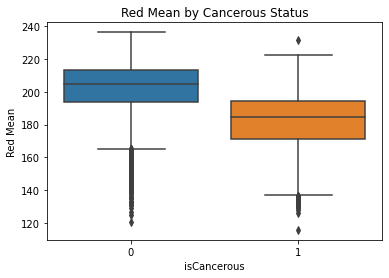

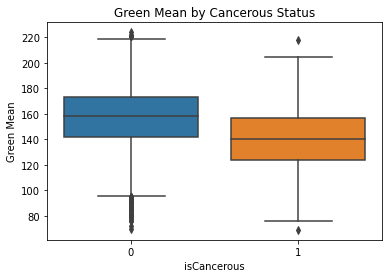

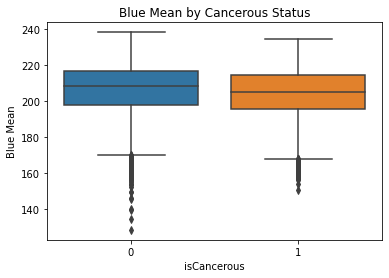

In [67]:
# Check for color distribution
colors = ['Red', 'Green', 'Blue']
for color in colors:
    color_values = []
    for img_name in data['ImageName']:
        img = Image.open('Image_classification_data/patch_images/' + img_name)
        color_values.append(np.mean(np.array(img)[:,:,colors.index(color)]))
    data[color + ' Mean'] = color_values
sns.boxplot(x='isCancerous', y='Red Mean', data=data)
plt.title('Red Mean by Cancerous Status')
plt.show()
sns.boxplot(x='isCancerous', y='Green Mean', data=data)
plt.title('Green Mean by Cancerous Status')
plt.show()
sns.boxplot(x='isCancerous', y='Blue Mean', data=data)
plt.title('Blue Mean by Cancerous Status')
plt.show()

**Observations**
- Non Cancerous cells have higher values of the color red
- Non Cancerous cells have higher values of the color Green
- Color of Blue is mostly evenly distributed among Cancerous and non cancerous images

In [66]:
# Check for edge cases
edge_cases = []
for img_name in data['ImageName']:
    img = Image.open('Image_classification_data/patch_images/' + img_name)
    if np.max(np.array(img)) > 255:
        edge_cases.append(img_name)
print('Number of edge cases:', len(edge_cases))

if(len(edge_cases)>=1):
    print('Example edge case:', edge_cases[0])
    img = Image.open('Image_classification_data/patch_images/' + edge_cases[0])
    plt.imshow(img)
    plt.title('Example Edge Case')
    plt.show()

Number of edge cases: 0
